# Simple landscape exploration

Written by Simon M. Mudd at the University of Edinburgh. Updated 24/09/2020

## What is this notebook?

This is a template notebook for getting some data and then doing simple analyses:
* Getting a hillshade
* Getting a slope map
* Extracting channels
* Looking at the resulting data

## First steps: install some packages

Lets get some of the python packages we need:

In [1]:
!pip install lsdviztools lsdttparamselector

     |████████████████████████████████| 268 kB 3.1 MB/s eta 0:00:01


  Created wheel for lsdttparamselector: filename=lsdttparamselector-0.1.0-py2.py3-none-any.whl size=8011 sha256=68db79fc5566bfffa71879aac4306fde8bb5a35797eb583c1d963619c4528090
  Stored in directory: /root/.cache/pip/wheels/3f/c8/11/6730e28be07db10ce8650d435d884302e04f483be85297c826
Successfully built lsdttparamselector


Now impoort some packages for looking at the data:

In [2]:
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw
import lsdttparamselector as ps
import pandas as pd
import geopandas as gpd
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

## Now grab some data

First, we need to grab some data. We use a tool in `lsdviztools.lsdbasemaptools` called the `ot_scraper` (`ot` is for opentopography.org).

You can tell this what sort of data you want (most people will use the SRTM 30 metre data) and you also tell it the lower left and the upper right corners, using latitude and longitude. You can get these from goole earth by right clickjing on the map and selecting "what's here". In this example I use a place near Santa Barbara, California. 

In [3]:
SB_DEM = bmt.ot_scraper(source = "SRTM30",longitude_W = -120.464655, longitude_E = -120.254214, latitude_S = 34.440538, latitude_N = 34.610770,prefix = "lg_conception")
SB_DEM.print_parameters()
SB_DEM.download_pythonic()

The source is: SRTM30
The west longitude is: -120.464655
The east longitude is: -120.254214
The south latitude is: 34.61077
The north latitude is: 34.440538
The path is: ./
The prefix is: lg_conception
I am going to download the following for you:
https://portal.opentopography.org/otr/getdem?demtype=SRTMGL1&south=34.440538&north=34.61077&west=-120.464655&east=-120.254214&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
Finished downloading


('./lg_conception_SRTM30.tif', './', 'lg_conception_SRTM30.tif')

We need to convert the data because we are going to use some other software to analyse it.

In [4]:
DataDirectory = "./"
RasterFile = "lg_conception_SRTM30.tif"
gio.convert4lsdtt(DataDirectory, RasterFile,minimum_elevation=0.01,resolution=30)

The projections is:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
And some extra projection information strings:
None
WGS 84
The centre of the raster is at:
(-120.37972222221434, 34.50555555555218)
dem_data.width is: 758
The latitude and longitude is
34.50555555555218 -120.37972222221434
res tuple is:
(30, 30)
The destination CRS is: EPSG:32610
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 661, 'height': 647, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 732452.2754693646,
       0.0, -30.0, 3833330.7356094)}
Removing pixels with an elevation less than 0.01


'lg_conception_SRTM30_UTM.tif'

## Now we do some topographic analysis

We will extract some topogaphic metrics using `lsdtopotools`. You will need to install `lsdtopotools` for this. If you have `conda` install on your system you can install it with `!conda install -c conda-forge lsdtopotools`.

Here we assume `lsdtopotools` is installed. 

The `lsdtt_parameters` are the various parametes that you can use to run an analysis. We will discuss these later. For now, we will just follow this recipie. 

In [5]:
lsdtt_parameters = {"write_hillshade" : "true",  
                    "surface_fitting_radius" : "60",
                    "print_slope" : "true"}
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = "lg_conception_SRTM30_UTM",
                                 write_prefix= "lg_conception_SRTM30_UTM",
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: lg_conception_SRTM30_UTM
The write prefix is: lg_conception_SRTM30_UTM
The parameter dictionary is:
{'write_hillshade': 'true', 'surface_fitting_radius': '60', 'print_slope': 'true'}


In [6]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


## Plot some data

We are now going to do some simple plots using a mapping package that we put together. There are more general ways to visualise data, but this makes pretty pictures quickly.  

Your colourbar will be located: right
xsize: 661 and y size: 647
NoData is: -9999.0
Let me get that projection for you
In this function I will extract the UTM zone
The dataset is projected.
The projection string is: WGS 84 / UTM zone 10N
WGS 84 / UTM zone 10N
This seems to be from the new gdal version
Zone string is: 10N
The zone is: 10
And the hemisphere is: N
The EPSG string is: epsg:32610
epsg:32610
minimum values are x: 732452.0 and y: 3813920.0
I made the ticks.
x labels are: 
['735', '738', '741', '744', '747', '750']
x locations are:
[735000.0, 738000.0, 741000.0, 744000.0, 747000.0, 750000.0]
y labels are: 
['3816', '3819', '3822', '3825', '3828', '3831']
y locations are:
[3816000.0, 3819000.0, 3822000.0, 3825000.0, 3828000.0, 3831000.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)
xsize: 661 and y size: 647
NoData is: -9999.0


findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


Let me get that projection for you
In this function I will extract the UTM zone
The dataset is projected.
The projection string is: WGS 84 / UTM zone 10N
WGS 84 / UTM zone 10N
This seems to be from the new gdal version
Zone string is: 10N
The zone is: 10
And the hemisphere is: N
The EPSG string is: epsg:32610
epsg:32610
I am going to use the normalisation None
I am using the full range of values in the raster.
The number of axes are: 2
The aspect ratio is: 1.0216383307573416
I need to adjust the spacing of the colourbar.
You have a colourbar on the left or right, I need to check the number of characters in the labels.
['', '']
The longest colourbar label has 0 characters.
The cbar characters are: 0 and the cbar text width is: 0.4
cbar_left: 5.449999999999999 map left: 0.8500000000000001
cbar_bottom: 0.65 map bottom: 0.65
The figure size is: 
[6.25, 5.254689863842663]
Map axes are:
[0.136, 0.12369902255747332, 0.72, 0.8382397397325347]
cbar_axes are:
[0.8719999999999999, 0.1236990225574

<Figure size 432x288 with 0 Axes>

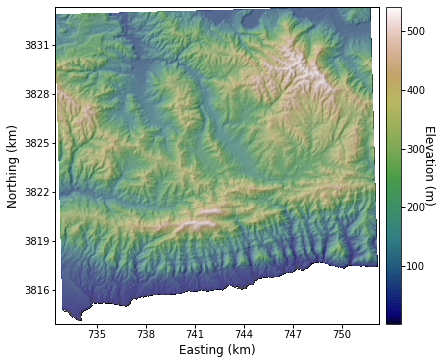

In [7]:
%matplotlib inline
Base_file = "lg_conception_SRTM30_UTM"
DataDirectory = "./"
this_img = lsdmw.SimpleHillshade(DataDirectory,Base_file,cmap="gist_earth", save_fig=False, size_format="geomorphology")

Your colourbar will be located: right
xsize: 661 and y size: 647
NoData is: -9999.0
Let me get that projection for you
In this function I will extract the UTM zone
The dataset is projected.
The projection string is: WGS 84 / UTM zone 10N
WGS 84 / UTM zone 10N
This seems to be from the new gdal version
Zone string is: 10N
The zone is: 10
And the hemisphere is: N
The EPSG string is: epsg:32610
epsg:32610
minimum values are x: 732452.0 and y: 3813920.0
I made the ticks.
x labels are: 
['735', '738', '741', '744', '747', '750']
x locations are:
[735000.0, 738000.0, 741000.0, 744000.0, 747000.0, 750000.0]
y labels are: 
['3816', '3819', '3822', '3825', '3828', '3831']
y locations are:
[3816000.0, 3819000.0, 3822000.0, 3825000.0, 3828000.0, 3831000.0]
This colourmap is: gray
The number of axes are: 1
Axes(0,0;1x1)
Axes(0,0;1x1)
N axes are: 1
Axes(0,0;1x1)
xsize: 661 and y size: 647
NoData is: -9999.0
Let me get that projection for you
In this function I will extract the UTM zone
The dataset 

<Figure size 432x288 with 0 Axes>

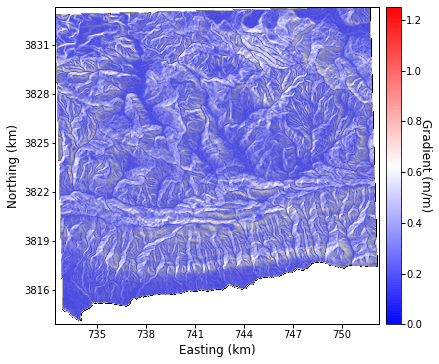

In [9]:
Base_file = "lg_conception_SRTM30_UTM"
Drape_prefix = "lg_conception_SRTM30_UTM_SLOPE"
DataDirectory = "./"
img_name2 = lsdmw.SimpleDrape(DataDirectory,Base_file, Drape_prefix, 
                              cmap = "bwr", cbar_loc = "right", 
                              cbar_label = "Gradient (m/m)",
                              save_fig=False, size_format="geomorphology",
                              colour_min_max = [0,1.25])

## Get some channel profiles

Okay, we will now run a different analysis. We will get some channel profiles. 

In [12]:
lsdtt_parameters = {"print_basin_raster" : "true",
                    "print_chi_data_maps" : "true"}
lsdtt_drive = lsdmw.lsdtt_driver(read_prefix = "lg_conception_SRTM30_UTM",
                                 write_prefix= "lg_conception_SRTM30_UTM",
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()

The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: lg_conception_SRTM30_UTM
The write prefix is: lg_conception_SRTM30_UTM
The parameter dictionary is:
{'print_basin_raster': 'true', 'print_chi_data_maps': 'true'}


In [13]:
lsdtt_drive.run_lsdtt_command_line_tool()

Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


Now we are going to read in the channel data using geopandas

In [14]:
df = pd.read_csv("lg_conception_SRTM30_UTM_chi_data_map.csv")

The csv file has latitude and longitude coordinates, so we can use these to register the geometry with a `geopandas` dataframe, and we can also set the coordinate reference system (`set_crs`). The `latitude` and `longitude` data produced by `lsdtopotools` is always in `epsg=4326`.

In [15]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
print(gdf.head())

    latitude   longitude     chi  elevation  flow_distance  drainage_area  \
0  34.562817 -120.295842  5.5467      397.0        27040.0       900000.0   
1  34.562547 -120.295850  5.5150      397.0        27010.0       900900.0   
2  34.562277 -120.295859  5.4834      395.0        26980.0       908100.0   
3  34.562006 -120.295868  5.4519      393.0        26950.0       916200.0   
4  34.561736 -120.295877  5.4206      389.0        26920.0       918000.0   

   source_key  basin_key                     geometry  
0           0          0  POINT (-120.29584 34.56282)  
1           0          0  POINT (-120.29585 34.56255)  
2           0          0  POINT (-120.29586 34.56228)  
3           0          0  POINT (-120.29587 34.56201)  
4           0          0  POINT (-120.29588 34.56174)  


So after some experimenting, it turns out that the plotting functions are not very happy if you don't keep everything in the same coordinate system. So I need to transform the geopandas dataframe to the correct UTM coordinate system. You will probably need to make sure your rasters and your dataframes are alyways in the same coordinate system.

We need to know what coordinate system our data is in. Lets find that out.

In [30]:
DEMdata = rio.open('lg_conception_SRTM30_UTM.bil')
bounds = DEMdata.bounds
DEMdata.crs

DEMHSdata = rio.open('lg_conception_SRTM30_UTM_hs.bil')
arrayHS = DEMHSdata.read(1)
arrayHS[arrayHS==-9999]=np.nan


Okay, now tell geopandas to convert the coordinate system

In [18]:
gdf2 = gdf.to_crs("EPSG:32610")

Lets have a look at these channels

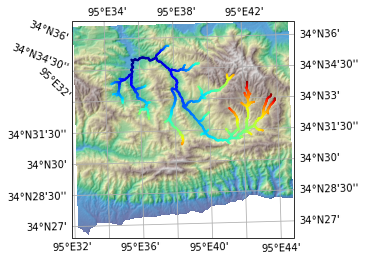

In [31]:
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]

array = DEMdata.read(1)
array[array<-5]=np.nan

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(46))
# Limit the extent of the map to a small longitude/latitude range.
#ax.set_extent(Extent, crs=ccrs.UTM(46))
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='terrain',alpha=0.5,zorder=-2)
ax.imshow(arrayHS, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='gray',alpha=1,zorder=-3)
gdf2.plot(ax=ax, markersize=1, column='chi', zorder=10,cmap="jet")
fig.savefig("test.png", dpi=800)
fig.show()

Okay, lets plot a channel profile! We first need to select a basin

In [21]:
gdf_b1 = gdf2[(gdf2['basin_key'] == 0)]
print(gdf_b1.head())

    latitude   longitude     chi  elevation  flow_distance  drainage_area  \
0  34.562817 -120.295842  5.5467      397.0        27040.0       900000.0   
1  34.562547 -120.295850  5.5150      397.0        27010.0       900900.0   
2  34.562277 -120.295859  5.4834      395.0        26980.0       908100.0   
3  34.562006 -120.295868  5.4519      393.0        26950.0       916200.0   
4  34.561736 -120.295877  5.4206      389.0        26920.0       918000.0   

   source_key  basin_key                        geometry  
0           0          0  POINT (748097.209 3827885.746)  
1           0          0  POINT (748097.278 3827855.752)  
2           0          0  POINT (748097.255 3827825.745)  
3           0          0  POINT (748097.232 3827795.749)  
4           0          0  POINT (748097.210 3827765.753)  


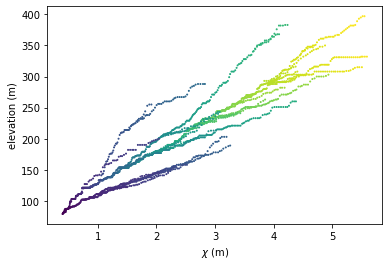

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(gdf_b1.chi,gdf_b1.elevation,c=gdf_b1.flow_distance,s=1)
plt.xlabel(r"$\chi$ (m)")
plt.ylabel("elevation (m)")
fig.show()

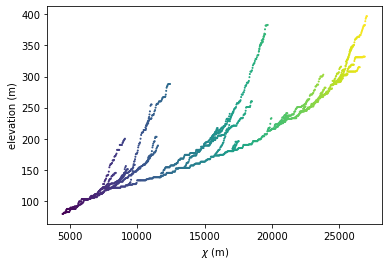

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(gdf_b1.flow_distance,gdf_b1.elevation,c=gdf_b1.flow_distance,s=1)
plt.xlabel(r"$\chi$ (m)")
plt.ylabel("elevation (m)")
fig.show()